In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import mediapipe as mp
from PIL import Image
import pickle
from warnings import filterwarnings

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.models import resnet18, ResNet18_Weights, resnet50, ResNet50_Weights
from torch.nn import Module, Linear, CrossEntropyLoss, Softmax
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


def set_seed(seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
filterwarnings('ignore')
set_seed(42)

In [3]:
IMG_DIR = '../data'

def get_df(path):
    labels = []
    img_path = []
    for label in os.listdir(path):
        for img in os.listdir(os.path.join(path, label)):
            labels.append(label)
            img_path.append(os.path.join(path, label, img))
    df = pd.DataFrame({'img_path': img_path, 'label': labels})
    return df

df = get_df(IMG_DIR)
df.head()

,img_path,label
0,../data\A\body dot (1).jpg,A
1,../data\A\body dot (2).jpg,A
2,../data\A\body dot (3).jpg,A
3,../data\A\body dot (4).jpg,A
4,../data\A\body white (1).jpg,A


Shape: (312, 2)
Total Classes: 26


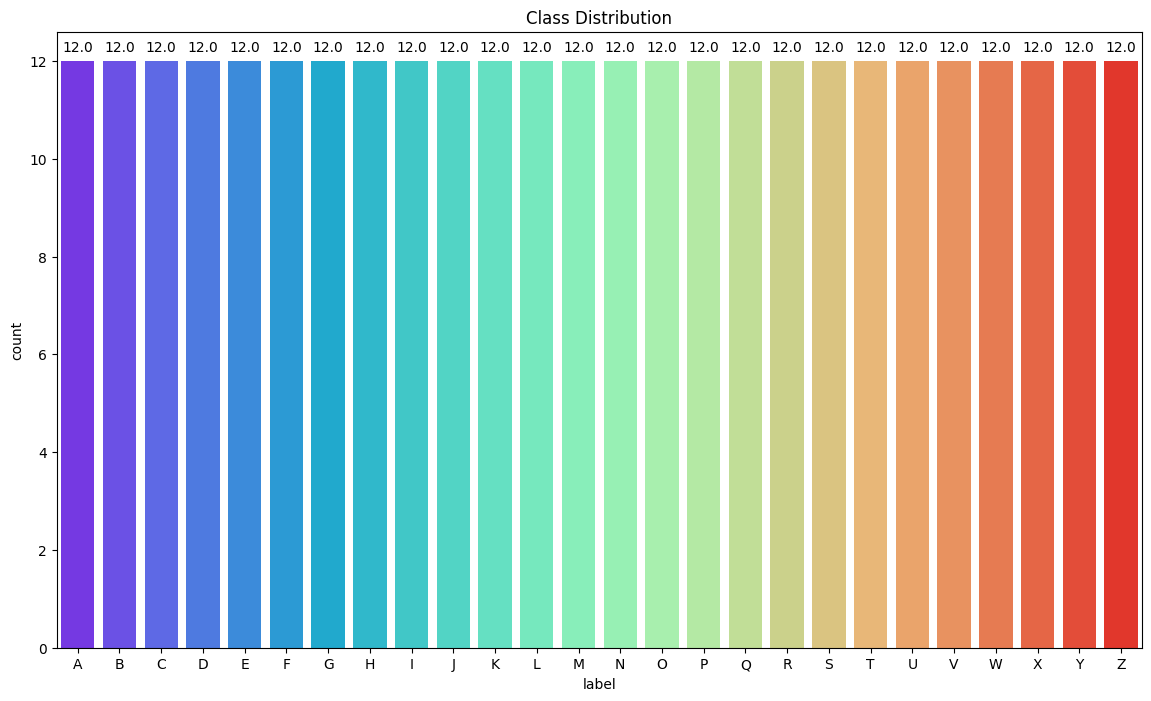

In [8]:
def summary(df):
    print(f"Shape: {df.shape}")
    print(f"Total Classes: {df['label'].nunique()}")

    plt.figure(figsize=(14, 8))
    ax = sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='rainbow')

    for value in ax.patches:
        ax.annotate(f'{value.get_height()}', 
                    (value.get_x() + value.get_width() / 2, value.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

    plt.title('Class Distribution')
    plt.xticks()
    plt.show()

summary(df)

In [ ]:
label_unique = df['label'].unique()
path_every_label = [df[df['label'] == label]['img_path'].values[0] for label in label_unique]
length = len(label_unique)
cols = 7
rows = length // cols + (length % cols > 0)
plt.figure(figsize=(20, 3 * rows))
for i, img_path in enumerate(path_every_label):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(label_unique[i])
    plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df['img_path'], df['label'], test_size=0.15, random_state=42, stratify=df['label']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_train.shape, X_val.shape, X_test.shape

((212,), (53,), (47,))

In [16]:
def read_img(all_paths):
    images = []
    for path in all_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        images.append(img.astype(np.uint8))
    return np.array(images)

X_train_imgs = read_img(X_train.values)
X_val_imgs = read_img(X_val.values)
X_test_imgs = read_img(X_test.values)

encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc = encoder.transform(y_val)
y_test_enc = encoder.transform(y_test)

X_train_imgs.shape, X_val_imgs.shape, X_test_imgs.shape

((212, 224, 224, 3), (53, 224, 224, 3), (47, 224, 224, 3))

In [33]:
with open('../artifacts/encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [ ]:
train_transform = v2.Compose([
    # change NumPy/Array (H, W, C) to Tensor (C, H, W)
    v2.ToImage(), 
    
    v2.RandomRotation(degrees=15),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    
    # ColorJitter needs either uint8 or float, v2 flexible
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),

    # Convert to Float32 and Scale (0-255 -> 0.0-1.0)
    v2.ToDtype(torch.float32, scale=True),

    # Normalize with ImageNet mean and std
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class SignLanguageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)
    
train_dataset = SignLanguageDataset(X_train_imgs, y_train_enc, transform=train_transform)
val_dataset = SignLanguageDataset(X_val_imgs, y_val_enc, transform=val_transform)
test_dataset = SignLanguageDataset(X_test_imgs, y_test_enc, transform=val_transform)
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [35]:
class SignLanguageModel(Module):
    def __init__(self, hidden_size, dropout_size, num_classes, freeze_backbone=False):
        super(SignLanguageModel, self).__init__()
        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.backbone.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_size),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SignLanguageModel(hidden_size=128, dropout_size=0.2, num_classes=df['label'].nunique())
model = model.to(device)

criterion = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
    return epoch_loss, epoch_f1

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
    return epoch_loss, epoch_f1

EPOCHS = 20
best_val_f1 = 0.0
best_loss = float('inf')
for epoch in range(EPOCHS):
    train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_f1 = eval_epoch(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pth')
        print(" => Best model saved!")
    elif val_f1 == best_val_f1 and val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(" => Best model saved based on loss!")

Epoch 1/20
Train Loss: 3.2703, Train F1: 0.0240
Val Loss: 3.2108, Val F1: 0.0017
 => Best model saved!
Epoch 2/20
Train Loss: 3.0031, Train F1: 0.1697
Val Loss: 2.9988, Val F1: 0.1461
 => Best model saved!
Epoch 3/20
Train Loss: 2.7483, Train F1: 0.4137
Val Loss: 2.7387, Val F1: 0.2769
 => Best model saved!
Epoch 4/20
Train Loss: 2.5383, Train F1: 0.5357
Val Loss: 2.4132, Val F1: 0.5182
 => Best model saved!
Epoch 5/20
Train Loss: 2.2054, Train F1: 0.7484
Val Loss: 2.1113, Val F1: 0.5865
 => Best model saved!
Epoch 6/20
Train Loss: 1.8800, Train F1: 0.8173
Val Loss: 1.7413, Val F1: 0.7335
 => Best model saved!
Epoch 7/20
Train Loss: 1.5977, Train F1: 0.9127
Val Loss: 1.4145, Val F1: 0.7939
 => Best model saved!
Epoch 8/20
Train Loss: 1.3367, Train F1: 0.9364
Val Loss: 1.1604, Val F1: 0.8063
 => Best model saved!
Epoch 9/20
Train Loss: 1.0933, Train F1: 0.9273
Val Loss: 0.9757, Val F1: 0.8216
 => Best model saved!
Epoch 10/20
Train Loss: 0.8762, Train F1: 0.9469
Val Loss: 0.7903, Val F1

Classification Report ResNet18:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         2
           C       1.00      1.00      1.00         2
           D       1.00      1.00      1.00         2
           E       1.00      1.00      1.00         2
           F       1.00      1.00      1.00         2
           G       1.00      1.00      1.00         2
           H       1.00      1.00      1.00         2
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         2
           K       1.00      1.00      1.00         2
           L       1.00      1.00      1.00         1
           M       0.67      1.00      0.80         2
           N       1.00      0.50      0.67         2
           O       1.00      1.00      1.00         2
           P       1.00      1.00      1.00         2
           Q       1.00      1.00      1.00      

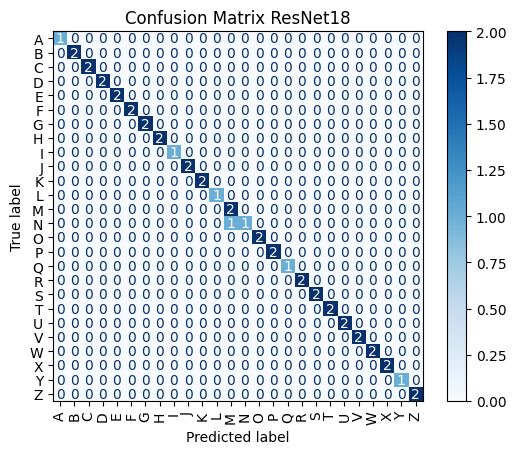

In [42]:
model = SignLanguageModel(hidden_size=128, dropout_size=0.2, num_classes=df['label'].nunique())
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

with torch.no_grad():
    model.eval()
    all_preds = []
    all_labels = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    print("Classification Report ResNet18:")
    print(classification_report(all_labels, all_preds, target_names=encoder.classes_))
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title('Confusion Matrix ResNet18')
    plt.show()



In [43]:
X_test_imgs[0].shape

(224, 224, 3)

In [ ]:
sample_test = X_test_imgs[0]
img_transform = val_transform(sample_test)
img_transform = img_transform.unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(img_transform)
    _, pred = torch.max(output, 1)
    conf = nn.Softmax(dim=1)(output)
    predicted_label = encoder.inverse_transform(pred.cpu().numpy())
    print(f"Predicted Label: {predicted_label[0]}")
    print(f"Confidence: {conf[0][pred].item()*100:.2f}%")

Predicted Label: X
Confidence: 94.75%


In [50]:
img_transform.shape

torch.Size([1, 3, 224, 224])

In [36]:
# freeze resnet

model = SignLanguageModel(hidden_size=128, dropout_size=0.2, num_classes=df['label'].nunique(), freeze_backbone=True)
model = model.to(device)

criterion = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
EPOCHS = 20
best_val_f1 = 0.0
best_loss = float('inf')

for epoch in range(EPOCHS):
    train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_f1 = eval_epoch(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model_freeze.pth')
        print(" => Best model saved!")
    elif val_f1 == best_val_f1 and val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_freeze.pth')
        print(" => Best model saved based on loss!")

Epoch 1/20
Train Loss: 3.2974, Train F1: 0.0271
Val Loss: 3.2803, Val F1: 0.0126
 => Best model saved!
Epoch 2/20
Train Loss: 3.2664, Train F1: 0.0323
Val Loss: 3.2586, Val F1: 0.0069
Epoch 3/20
Train Loss: 3.2486, Train F1: 0.0284
Val Loss: 3.2393, Val F1: 0.0194
 => Best model saved!
Epoch 4/20
Train Loss: 3.2300, Train F1: 0.0577
Val Loss: 3.2241, Val F1: 0.0624
 => Best model saved!
Epoch 5/20
Train Loss: 3.2244, Train F1: 0.0324
Val Loss: 3.2060, Val F1: 0.0635
 => Best model saved!
Epoch 6/20
Train Loss: 3.1903, Train F1: 0.0560
Val Loss: 3.1924, Val F1: 0.0994
 => Best model saved!
Epoch 7/20
Train Loss: 3.2107, Train F1: 0.0676
Val Loss: 3.1774, Val F1: 0.1296
 => Best model saved!
Epoch 8/20
Train Loss: 3.1655, Train F1: 0.0933
Val Loss: 3.1639, Val F1: 0.1362
 => Best model saved!
Epoch 9/20
Train Loss: 3.1741, Train F1: 0.0798
Val Loss: 3.1498, Val F1: 0.1499
 => Best model saved!
Epoch 10/20
Train Loss: 3.1469, Train F1: 0.1257
Val Loss: 3.1334, Val F1: 0.1474
Epoch 11/20
T

In [37]:
X_train_imgs.shape

(212, 224, 224, 3)

In [38]:
# resnet as extractor

base_model = resnet18(weights=ResNet18_Weights.DEFAULT)
model = nn.Sequential(*list(base_model.children())[:-1])

model = model.to(device)

def extract_features_resnet(images):
    features = []
    with torch.no_grad():
        for image in images:
            image = image.astype(np.uint8)
            image = val_transform(image).unsqueeze(0).to(device)
            output = model(image)
            output = output.squeeze().cpu().numpy()
            features.append(output)
    return np.array(features)

print("Extracting train features...")
X_train_features = extract_features_resnet(X_train_imgs)
print("Extracting validation features...")
X_val_features = extract_features_resnet(X_val_imgs)

Extracting train features...
Extracting validation features...


In [39]:
X_train_features.shape, X_val_features.shape

((212, 512), (53, 512))

Model: XGBoost
XGBoost Validation F1 Score: 0.1630
              precision    recall  f1-score   support

           A       0.20      0.50      0.29         2
           B       0.00      0.00      0.00         2
           C       0.00      0.00      0.00         2
           D       0.50      0.50      0.50         2
           E       0.00      0.00      0.00         2
           F       0.00      0.00      0.00         2
           G       0.33      0.50      0.40         2
           H       0.50      0.50      0.50         2
           I       0.00      0.00      0.00         2
           J       0.00      0.00      0.00         2
           K       0.00      0.00      0.00         2
           L       0.00      0.00      0.00         2
           M       0.33      0.50      0.40         2
           N       0.00      0.00      0.00         2
           O       0.00      0.00      0.00         2
           P       0.00      0.00      0.00         2
           Q       0.00      0

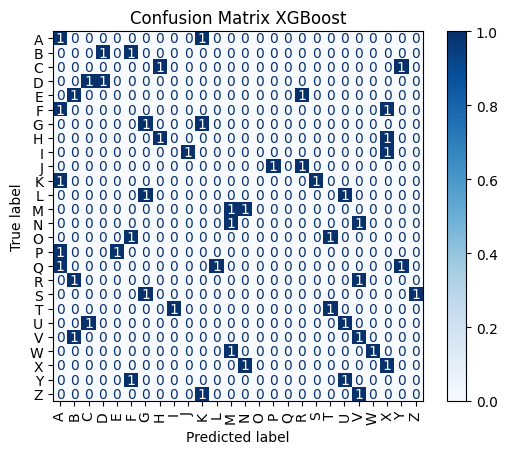

Model: LightGBM
LightGBM Validation F1 Score: 0.3524
              precision    recall  f1-score   support

           A       0.40      1.00      0.57         2
           B       0.50      0.50      0.50         2
           C       0.00      0.00      0.00         2
           D       0.50      0.50      0.50         2
           E       0.50      0.50      0.50         2
           F       0.50      0.50      0.50         2
           G       1.00      0.50      0.67         2
           H       0.50      0.50      0.50         2
           I       0.50      0.50      0.50         2
           J       0.00      0.00      0.00         2
           K       0.00      0.00      0.00         2
           L       0.00      0.00      0.00         2
           M       0.67      1.00      0.80         2
           N       0.00      0.00      0.00         2
           O       0.50      0.50      0.50         2
           P       0.33      0.50      0.40         2
           Q       0.00     

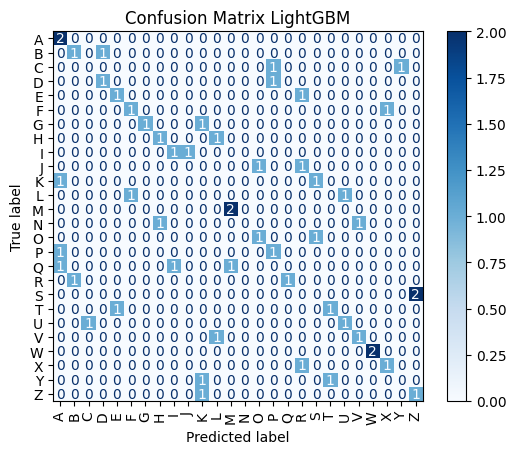

In [41]:
estimators = [
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ('LightGBM', LGBMClassifier(verbose=-1)),
]

for name, model in estimators:
    print(f"Model: {name}")
    model.fit(X_train_features, y_train_enc)
    val_preds = model.predict(X_val_features)
    val_f1 = f1_score(y_val_enc, val_preds, average='weighted')
    print(f"{name} Validation F1 Score: {val_f1:.4f}")
    print(classification_report(y_val_enc, val_preds, target_names=encoder.classes_))
    cm = confusion_matrix(y_val_enc, val_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f'Confusion Matrix {name}')
    plt.show()